# Stock Prediction

This project introduces common techniques to manipulate time series and make predictions.

The data is a sample from the historical US stock prices in the last 5 years. Only the New German Fund (GF) will be considered for analysis.

There roughly 1000 days of recoreded trading for GF.

<a id="table_of_contents"></a>

1. [Import Libraries](#import_libraries)
2. [Import Data](#import_data)
3. [Data Cleaning](#data_cleaning)
4. [Data Exploration](#data_exploration)
5. [Data Preparation](#data_preparation)
6. [Benchmark Model](#benchmark_model)<br>
    6.1. [Train-Test Split](#train_test_split)<br>
    6.2. [Fit a Model to the Data](#fit_a_model_to_the_data)<br>
    6.3. [Model Evaluation](#model_evaluation)
7. [Feature Engineering](#feature_engineering)
8. [Model Training](#model_training)
9. [Hyperparameters Tuning](#hyperparameters_tuning)

## 1. Import Libraries <a id="import_libraries"></a> 
[Back to top](#table_of_contents) 

In [1]:
%%time

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set() 

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt 
import statsmodels.api as sm 

from tqdm import tqdm_notebook

from itertools import product 

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)/y_true)) * 100

%matplotlib inline

Wall time: 3.44 s


## 2. Import Data <a id="import_data"></a>
[Back to top](#table_of_contents)

In [2]:
%%time

data = pd.read_csv('data/stock_prices_sample.csv', index_col=['DATE'], parse_dates=['DATE'])
data.head()

Wall time: 15.9 ms


,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0


In [4]:
data.shape

(999, 17)

In [5]:
data.dtypes

TICKER          object
FIGI            object
TYPE            object
FREQUENCY       object
OPEN           float64
HIGH           float64
LOW            float64
CLOSE          float64
VOLUME         float64
ADJ_OPEN       float64
ADJ_HIGH       float64
ADJ_LOW        float64
ADJ_CLOSE      float64
ADJ_VOLUME     float64
ADJ_FACTOR     float64
EX_DIVIDEND    float64
SPLIT_RATIO    float64
dtype: object

## 3. Data Cleaning <a id="data_cleaning"></a>
[Back to top](#table_of_contents)

In [20]:
data_gf = data[data.TICKER != 'GEF'] # we only care about New Germany Fund (GF)
data_gf = data_gf[data_gf.TYPE != 'Intraday'] # we only want EOD information

# We solely want to focus on the stock's closing price
drop_cols = ['SPLIT_RATIO', 'EX_DIVIDEND', 'ADJ_FACTOR', 'ADJ_CLOSE', 'ADJ_LOW', 'ADJ_HIGH',
             'ADJ_OPEN', 'VOLUME', 'FREQUENCY', 'TYPE', 'FIGI']

data_gf.drop(drop_cols, axis=1, inplace=True)

data_gf.head()

,TICKER,OPEN,HIGH,LOW,CLOSE,ADJ_VOLUME
DATE,,,,,,
2018-06-04,GF,18.86,18.890,18.7900,18.8100,39095.0
2018-06-01,GF,18.58,18.760,18.5800,18.7400,17468.0
2018-05-31,GF,18.52,18.520,18.3012,18.4900,22384.0
2018-05-30,GF,18.47,18.678,18.4700,18.6500,22633.0
2018-05-29,GF,18.51,18.510,18.1500,18.2562,67412.0


## 4. Data Exploration <a id="data_exploration"></a>
[Back to top](#table_of_contents)

We plot the closing price over the entire time period of the dataset.

We can see that this is not a **stationary** procress, and it is hard to tell if there is some kind of **seasonality**. 

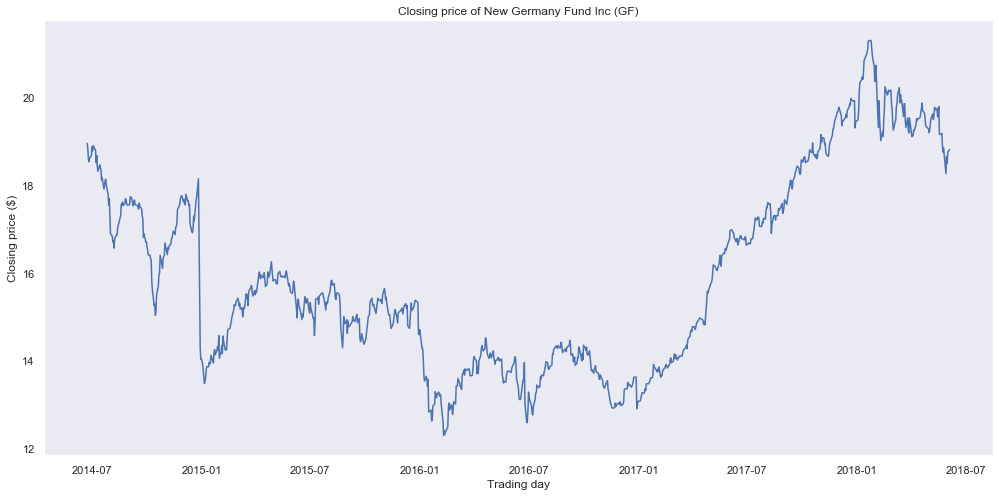

In [23]:
plt.figure(figsize=(17, 8))
plt.plot(data_gf.CLOSE)
plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)
plt.show()

### Moving Average

Let's use the **moving average** model to smooth our time series. For that, we will use a helper function that will run the moving average model on a specified time window and it will plot the result smoothed curve.

In [35]:
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):
    """
    This function plots the moving average of a time series. 

    Inputs:
    series: pandas.Series
    window: int
    plot_intervals: boolean 
    scale: float
    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(20,10))
    plt.title('Moving Average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling Mean Trend')

    if plot_intervals==True:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])

        lower_bound = rolling_mean - (mae + scale *deviation)
        upper_bound = rolling_mean + (mae + scale *deviation)

        plt.plot(lower_bound, 'r--', label='Upper Bound / Lower Bound')
        plt.plot(upper_bound, 'r--')

    plt.plot(series[window:], label='Actual Values')
    plt.legend()
    plt.grid(True)

For a time window of 3 days,  we can hardly see a trend, because it is too close to the actual curve. 

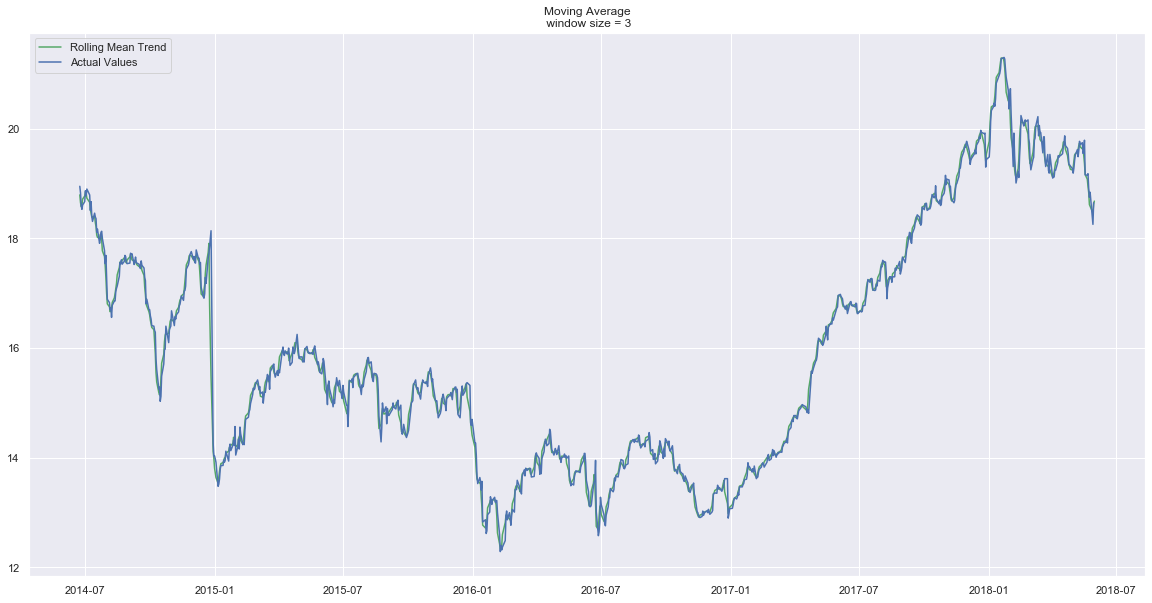

In [36]:
plot_moving_average(data_gf.CLOSE, window=3)

Smoothing by 30 days 

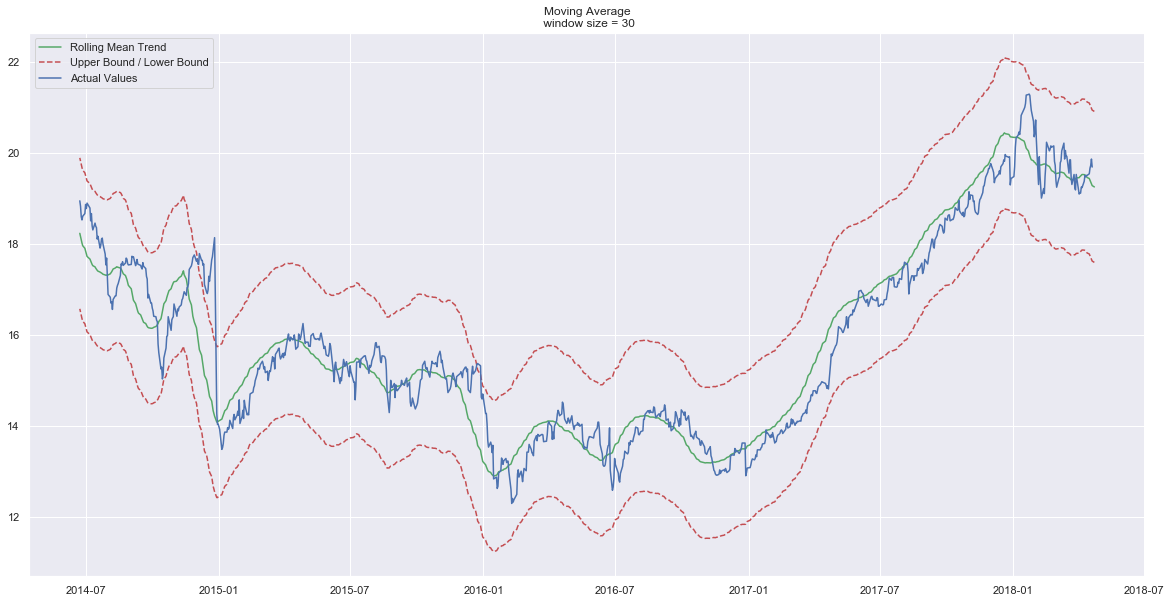

In [37]:
plot_moving_average(data_gf.CLOSE, window=30, plot_intervals=True)


Smoothing by 90 days.

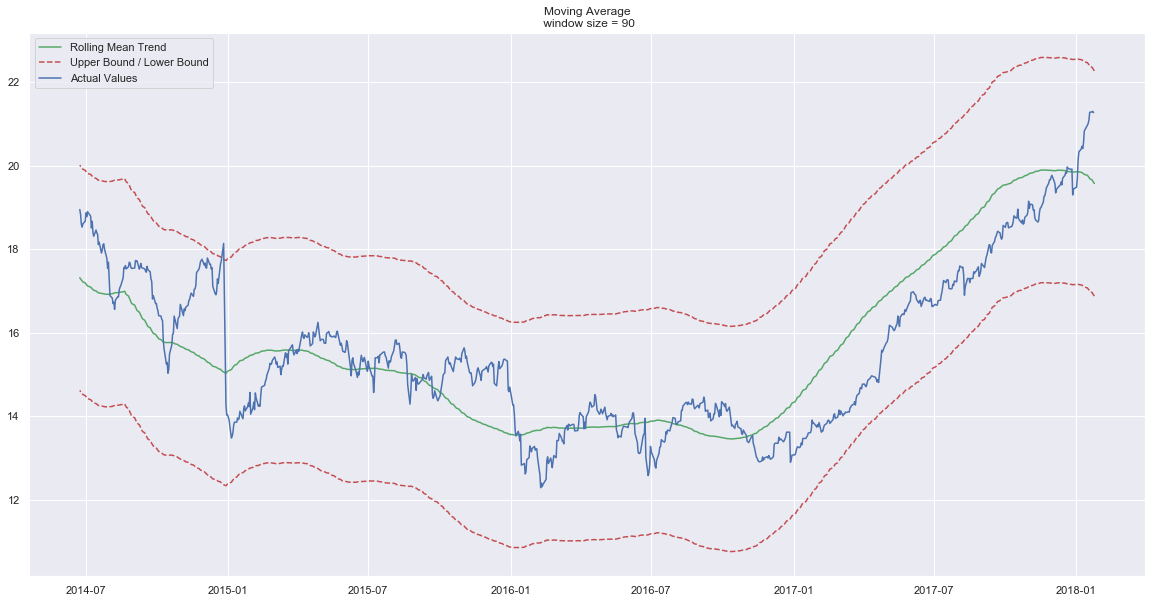

In [38]:
plot_moving_average(data_gf.CLOSE, window=90, plot_intervals=True)